In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, Matern
from GP import GaussianProcessRegressor

In [3]:
datasets = 1
n = 15
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                 # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = (0.5-np.random.rand(n) + energies)                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
    dataset_sizes[i] = n

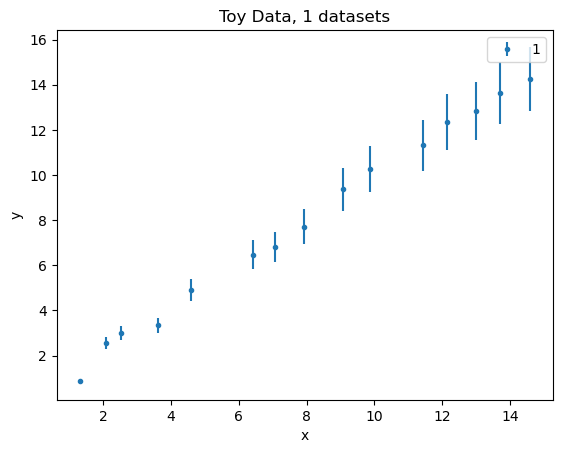

<Figure size 640x480 with 0 Axes>

In [4]:
# Plot the model data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

In [5]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
#kernel =  ConstantKernel(magnitude) *RBF(length_scale) 
#kernel = ConstantKernel(magnitude) * RBF(length_scale) * DotProduct(1)
kernel = ConstantKernel(magnitude) * Matern(length_scale, nu=2.5)
num_test = 300
x_test = np.linspace(0.5, n+0.5, num_test)

uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total=total_errors)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_theta = uncorrelated_gp.get_hyperparameter_values()

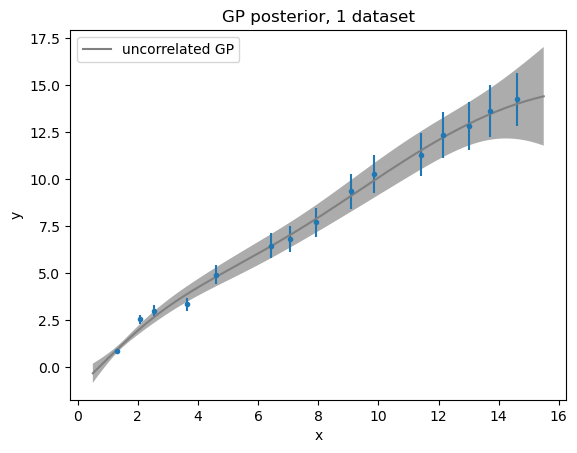

In [6]:
# Plot posterior

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'GP posterior, {datasets} dataset')
plt.show()

In [7]:
#percent_correlations = np.linspace(0,1,6)          # Percent of total error that is correlated with other data points
percent_correlations = [0.0,0.5,0.8,1]

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    print(correlated_gp.get_hyperparameter_values())
    print(eigvals(correlated_K11))
    #print(inv(correlated_K11))
    print()


0.0
[137.26737902  14.63952849]
[1.83548231e+03+0.j 2.06244577e+02+0.j 1.77735398e+01+0.j
 2.75229969e+00+0.j 1.88174231e+00+0.j 1.65278304e+00+0.j
 1.45644975e+00+0.j 1.20681356e+00+0.j 9.48014753e-01+0.j
 6.05181659e-02+0.j 9.42627670e-02+0.j 1.80636927e-01+0.j
 6.54843247e-01+0.j 4.82089291e-01+0.j 4.10163969e-01+0.j]

0.5
[113.11845936  12.58294774]
[1.46633116e+03+0.j 2.10326101e+02+0.j 2.20401027e+01+0.j
 3.13022283e+00+0.j 1.47035053e+00+0.j 1.29640650e+00+0.j
 1.16145731e+00+0.j 9.80100650e-01+0.j 7.47372128e-01+0.j
 5.64894101e-01+0.j 4.93736127e-02+0.j 7.65414748e-02+0.j
 1.51919648e-01+0.j 3.95956023e-01+0.j 3.25296753e-01+0.j]

0.8
[70.09676076  7.85669614]
[7.84879551e+02+0.j 2.21790820e+02+0.j 4.34104055e+01+0.j
 7.59471530e+00+0.j 2.26810626e+00+0.j 9.45059226e-01+0.j
 6.80587019e-01+0.j 5.97419943e-01+0.j 5.06869854e-01+0.j
 3.70579690e-01+0.j 2.77982756e-02+0.j 5.97018835e-02+0.j
 2.64765348e-01+0.j 1.46515184e-01+0.j 1.78877942e-01+0.j]

1
[1.e-05 1.e+05]
[1.22704775e

/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


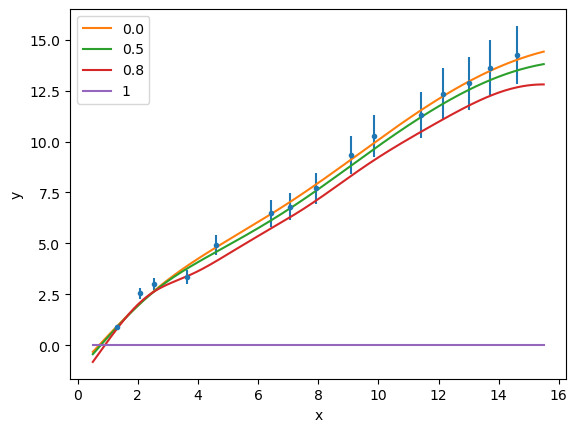

In [8]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
    #plt.fill_between(x_test, correlated_mean - uncorrelated_std, correlated_mean + uncorrelated_std, alpha=0.65, edgecolor='none')

plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.show()


What happens if the kernel hyperparameters are fixed to some other values?

In [12]:
uncorrelated_theta = [80,4]

#fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * RBF(uncorrelated_theta[1], length_scale_bounds='fixed') 
fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * Matern(uncorrelated_theta[1], length_scale_bounds='fixed') 

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    print(eigvals(correlated_K11))
    #print(correlated_K11)
    print()


0.0
[5.86631363e+02+0.j 3.39054837e+02+0.j 1.59850056e+02+0.j
 5.71277974e+01+0.j 2.83967054e+01+0.j 1.63337826e+01+0.j
 6.87595670e+00+0.j 5.21678790e+00+0.j 3.69527819e+00+0.j
 3.14534115e-01+0.j 9.39916500e-01+0.j 2.59315196e+00+0.j
 1.45700945e+00+0.j 1.76772970e+00+0.j 2.01545524e+00+0.j]

0.5
[5.88847673e+02+0.j 3.39402724e+02+0.j 1.59705556e+02+0.j
 5.69193340e+01+0.j 2.81994565e+01+0.j 1.61180438e+01+0.j
 6.58898642e+00+0.j 5.04113552e+00+0.j 3.53315119e+00+0.j
 2.95524770e-01+0.j 8.22096940e-01+0.j 2.21229049e+00+0.j
 1.37469762e+00+0.j 1.51860727e+00+0.j 1.69108259e+00+0.j]

0.8
[5.92322956e+02+0.j 3.39929523e+02+0.j 1.59479252e+02+0.j
 5.65953604e+01+0.j 2.78951948e+01+0.j 1.57794524e+01+0.j
 6.19483863e+00+0.j 4.74309101e+00+0.j 3.26715275e+00+0.j
 2.65758604e-01+0.j 1.66236900e+00+0.j 1.40955334e+00+0.j
 6.31920762e-01+0.j 1.16021512e+00+0.j 9.33723308e-01+0.j]

1
[5.95549661e+02+0.j 3.40399082e+02+0.j 1.59269435e+02+0.j
 5.62976517e+01+0.j 2.76180164e+01+0.j 1.54647155e+0

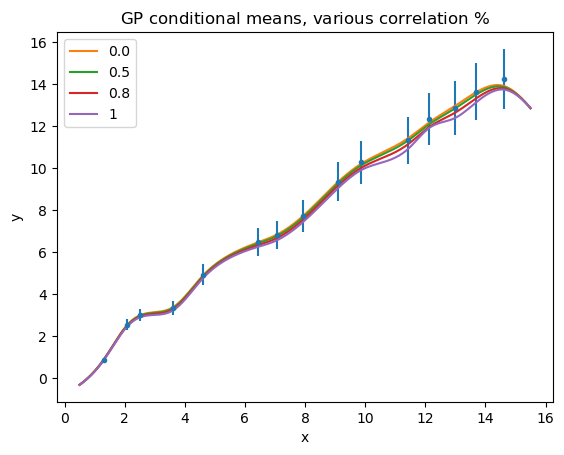

In [15]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(r'GP conditional means, various correlation $\%$')
plt.show()

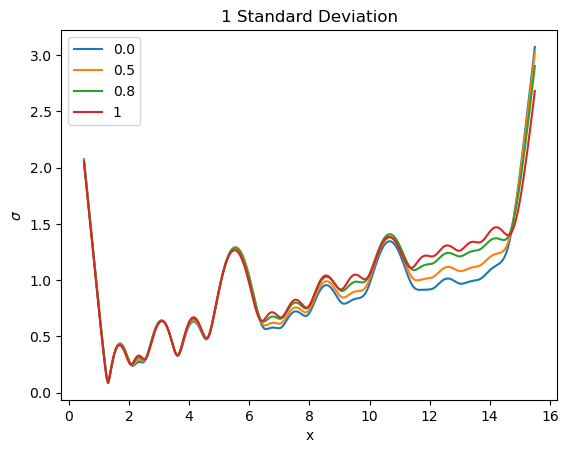

In [16]:
for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_std, label=str(round(percent,2)))
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'$\sigma$')
plt.title('1 Standard Deviation')
plt.show()